In [4]:
from torch import IntTensor, load
import torch

device = torch.device('cuda')

# https://huggingface.co/datasets/Birchlabs/danbooru-caption-lengths/resolve/main/caption_token_lengths.pt
samp: IntTensor = load('/home/birch/ml-data/caption_token_lengths.pt', map_location=device, weights_only=True)

used 97 iterations (1.2154s) to cluster 5770089 items into 20 clusters
top 20 context lengths (º):
tensor([ 27.7495,  37.3900,  46.1920,  54.0640,  60.0144,  64.5037,  67.9982,
         70.9982,  74.4954,  79.4845,  86.4333,  95.3515, 106.2412, 119.4628,
        135.9877, 157.8479, 189.9467, 244.0055, 361.3772, 732.6708],
       device='cuda:0')


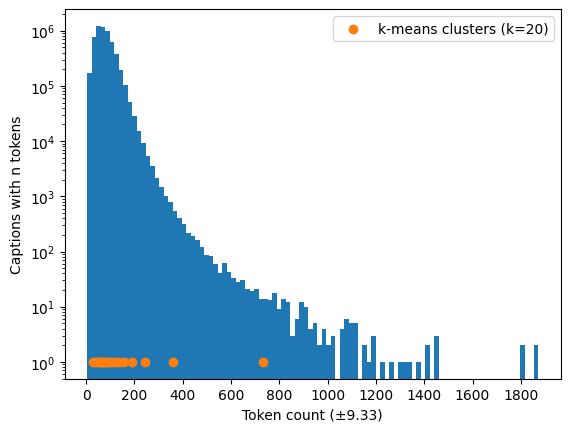

In [40]:
from kmeans_pytorch import kmeans
from fast_pytorch_kmeans import KMeans
from torch import histc, linspace, zeros_like, ones_like, FloatTensor
import matplotlib.pyplot as plt

bin_min, bin_max = samp.min(), samp.max()
bin_count = 100
bin_occupants: FloatTensor = histc(samp, bins = bin_count)
bins: FloatTensor = linspace(start=bin_min, end=bin_max, steps=bin_count, device=device)
bin_step: FloatTensor = (bin_max-bin_min)/(bin_count-1)
bin_half_step: FloatTensor = bin_step / 2
bin_mids: FloatTensor = bins + bin_half_step

n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, mode='euclidean', verbose=1, max_iter=5000)
kmeans.fit_predict(samp.float().unsqueeze(-1))
cluster_centers: FloatTensor = kmeans.centroids

plt.bar(x=bins.cpu(), height=bin_occupants.cpu(), width=bin_step.cpu())
# we use ones instead of zeros so that it survives the log scale
plt.scatter(cluster_centers.cpu(), ones_like(cluster_centers, device='cpu'), label=f'k-means clusters (k={n_clusters})')
plt.legend()
plt.xlabel(f'Token count (±{bin_half_step.item():.2f})')
plt.locator_params(nbins=20)
plt.ylabel('Captions with n tokens')
plt.yscale('log')
# expl = '''blah'''
# plt.figtext(0.5, -0.2, expl, wrap=True, horizontalalignment='center', fontsize=10)
cluster_centers, _ = cluster_centers.squeeze().sort()

print(f'top 20 context lengths (º):\n{cluster_centers}')

In [64]:
# buckets you'd need to satisfy in order to cover 99.5% of captions
bins[bin_occupants.cumsum(dim=0)<=samp.size(0)*.995]

tensor([ 14.0000,  32.6667,  51.3333,  70.0000,  88.6667, 107.3333, 126.0000,
        144.6667, 163.3333, 182.0000, 200.6667], device='cuda:0')